In [3]:
import numpy as np
import pandas as pd
from vnstock import Vnstock
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy.optimize import minimize
import matplotlib.dates as mdates
import seaborn as sns
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from scipy.stats import gaussian_kde
from scipy.stats import beta, dirichlet, norm,invwishart, invgamma, beta
from scipy.special import gammaln, gamma
import pymc as pm
import pytensor.tensor as pt
import arviz as az
import time
from datetime import datetime
from scipy import stats


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/vnai/scope/profile.py:742: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Phiên bản Vnstock 3.2.6 đã có mặt, vui lòng cập nhật với câu lệnh : `pip install vnstock --upgrade`.
Lịch sử phiên bản: https://vnstocks.com/docs/tai-lieu/lich-su-phien-ban
Phiên bản hiện tại 3.2.5

# 0. OVERVIEW

In [ ]:
# Stock lists
ASSETS = ["HPG", "VCB", "CTG", "MSN", "MWG"]

# Period lists
date_ranges = {
    "2012_2015": ("2012-01-01", "2015-12-31"),
    "2016_2019": ("2016-01-01", "2019-12-31"),
    "2020_2021": ("2020-01-01", "2021-12-31"),
    "2022_2024": ("2022-01-01", "2024-12-31")
}

# Create dict to save data from each period
data_periods = {}

# Looping each period
for label, (start_date, end_date) in date_ranges.items():
    print(f"\n=== Loading data for {label} ({start_date} to {end_date}) ===")
    
    data = pd.DataFrame()
    
    # Download data
    for ticker in ASSETS:
        print(f"Downloading {ticker}...")
        stock = Vnstock().stock(symbol=ticker, source="VCI")
        df = stock.quote.history(start=start_date, end=end_date)
        df = df[["time", "close"]].rename(columns={"close": ticker})
        
        if data.empty:
            data = df.copy()
        else:
            data = pd.merge(data, df, on="time", how="outer")
    
    # set index
    data["time"] = pd.to_datetime(data["time"])
    data = data.sort_values("time").set_index("time")
    
    # Save to dict
    data_periods[label] = data

# Checking results
for key, df in data_periods.items():
    print(f"\n>>> {key}: {df.shape} rows")
    print(df.head())



=== Loading data for 2012_2015 (2012-01-01 to 2015-12-31) ===

=== Loading data for 2016_2019 (2016-01-01 to 2019-12-31) ===

=== Loading data for 2020_2021 (2020-01-01 to 2021-12-31) ===

=== Loading data for 2022_2024 (2022-01-01 to 2024-12-31) ===

>>> 2012_2015: (995, 5) rows
             HPG   VCB   CTG    MSN  MWG
time                                    
2012-01-03  0.66  4.75  6.26  45.55  NaN
2012-01-04  0.64  4.63  6.55  45.55  NaN
2012-01-05  0.62  4.61  6.52  44.52  NaN
2012-01-06  0.60  4.52  6.63  42.47  NaN
2012-01-09  0.60  4.66  6.66  42.98  NaN

>>> 2016_2019: (1001, 5) rows
             HPG    VCB    CTG    MSN   MWG
time                                       
2016-01-04  2.87  13.07  11.29  38.86  8.94
2016-01-05  2.84  12.86  11.17  38.61  8.94
2016-01-06  2.89  13.01  11.29  39.12  8.88
2016-01-07  2.81  12.86  11.17  39.89  8.60
2016-01-08  2.76  12.77  10.92  39.38  8.49

>>> 2020_2021: (502, 5) rows
             HPG    VCB    CTG    MSN    MWG
time             

In [5]:
data_12_15 = data_periods["2012_2015"]
daily_log_returns_12_15 = np.log(data_12_15).diff().dropna()
observed_12_15_daily_returns = daily_log_returns_12_15.values

data_16_19 = data_periods["2016_2019"]
daily_log_returns_16_19 = np.log(data_16_19).diff().dropna()
observed_16_19_daily_returns = daily_log_returns_16_19.values

data_20_21 = data_periods["2020_2021"]
daily_log_returns_20_21 = np.log(data_20_21).diff().dropna()
observed_20_21_daily_returns = daily_log_returns_20_21.values

data_22_24 = data_periods["2022_2024"]
daily_log_returns_22_24 = np.log(data_22_24).diff().dropna()
observed_22_24_daily_returns = daily_log_returns_22_24.values


In [6]:
RISK_FREE_RATE = 0.03

## Metropolis-Hasting Algorithm

## Create The Model

In [ ]:
#   DEFINE MH FUNCTION FLOW  
def run_metropolis_sampling(name, log_returns, draws=20000, tune=5000, kappa=5, eta=1.0, seed=42):
    """
    Run Metropolis sampling for a given period of log returns.
    
    Parameters:
        name (str): name of the period (e.g. "2012_2015")
        log_returns (pd.DataFrame): daily log returns
        draws, tune, kappa, eta: MH hyperparameters

    Returns:
        trace (arviz.InferenceData): sampling result
    """
    observed_returns = log_returns.values
    n_obs, n_assets = observed_returns.shape

    mu_0 = log_returns.mean().values * 252
    cov_annual = log_returns.cov().values * 252
    Sigma_0 = cov_annual / kappa

    with pm.Model() as model:
        # Prior for expected returns
        annual_returns = pm.MvNormal('annual_returns', mu=mu_0, cov=Sigma_0, shape=n_assets)

        # Prior for covariance matrix
        chol, corr, stds = pm.LKJCholeskyCov(
            'annual_cov',
            n=n_assets,
            eta=eta,
            sd_dist=pm.Exponential.dist(1.0),
            compute_corr=True
        )
        annual_cov = pm.Deterministic('annual_covariance_matrix', pt.dot(chol, chol.T))

        # Convert to daily
        daily_returns = pm.Deterministic('daily_returns', annual_returns / 252.0)
        daily_cov = pm.Deterministic('daily_cov', annual_cov / 252.0)

        # Likelihood
        likelihood = pm.MvNormal('observed_returns_likelihood', mu=daily_returns,
                                 cov=daily_cov, observed=observed_returns)

        trace = pm.sample(draws=draws,
                          tune=tune,
                          chains=2,
                          step=pm.Metropolis(),
                          cores=1,
                          return_inferencedata=True,
                          random_seed=seed)

    print(f"✅ Done sampling for {name}")
    return trace


In [8]:
# Dictionary save trace of each period
mh_traces_by_period = {}

# Looping each data_periods
for period_label, df in data_periods.items():
    print(f"\nRunning MH for period: {period_label}")

    # log return
    log_returns = np.log(df).diff().dropna()

    # Run Metropolis
    trace = run_metropolis_sampling(name=period_label, log_returns=log_returns)

    # Lưu trace
    mh_traces_by_period[period_label] = trace



Running MH for period: 2012_2015


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [annual_returns]
>Metropolis: [annual_cov]


install "ipywidgets" for Jupyter support

Sampling 2 chains for 5_000 tune and 20_000 draw iterations (10_000 + 40_000 draws total) took 102 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


✅ Done sampling for 2012_2015

Running MH for period: 2016_2019


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [annual_returns]
>Metropolis: [annual_cov]


install "ipywidgets" for Jupyter support

overflow encountered in exp

Sampling 2 chains for 5_000 tune and 20_000 draw iterations (10_000 + 40_000 draws total) took 153 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


✅ Done sampling for 2016_2019

Running MH for period: 2020_2021


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [annual_returns]
>Metropolis: [annual_cov]


install "ipywidgets" for Jupyter support

Sampling 2 chains for 5_000 tune and 20_000 draw iterations (10_000 + 40_000 draws total) took 115 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


✅ Done sampling for 2020_2021

Running MH for period: 2022_2024


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [annual_returns]
>Metropolis: [annual_cov]


install "ipywidgets" for Jupyter support

overflow encountered in exp

Sampling 2 chains for 5_000 tune and 20_000 draw iterations (10_000 + 40_000 draws total) took 134 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


✅ Done sampling for 2022_2024


## Run MCMC Sampling

## Analyze Result

array([[<Axes: title={'center': 'annual_returns'}>,
        <Axes: title={'center': 'annual_returns'}>]], dtype=object)

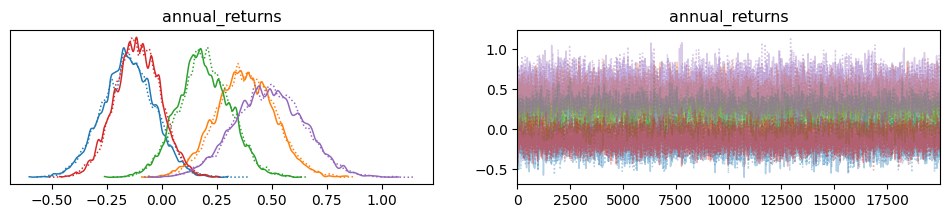

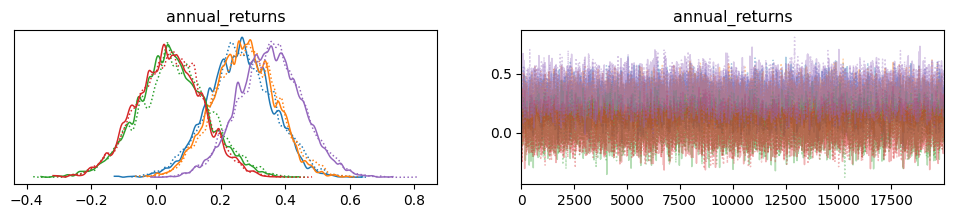

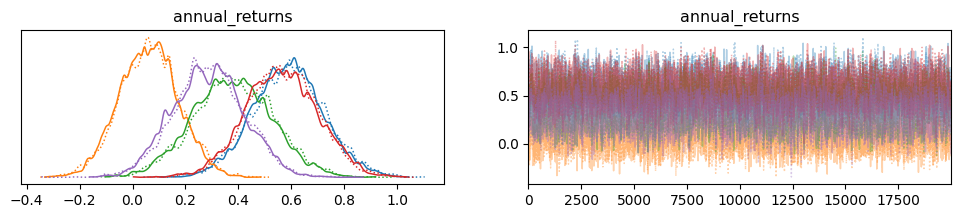

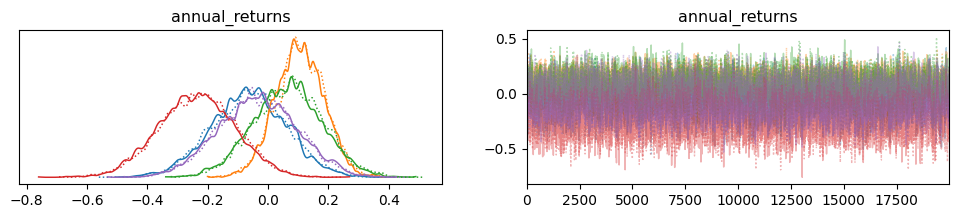

In [9]:
az.plot_trace(mh_traces_by_period["2012_2015"], var_names=["annual_returns"])
az.plot_trace(mh_traces_by_period["2016_2019"], var_names=["annual_returns"])
az.plot_trace(mh_traces_by_period["2020_2021"], var_names=["annual_returns"])
az.plot_trace(mh_traces_by_period["2022_2024"], var_names=["annual_returns"])

In [10]:
def optimize_sharpe_for_samples(mu_samples, cov_samples, risk_free_rate=0.03):
    """
    For all posterior samples, solve Markowitz optimization.
    
    Parameters:
    -----------
    mu_samples: (n_samples, n_assets)
    cov_samples: (n_samples, n_assets, n_assets)
    
    Returns:
    --------
    dict: Contains arrays of weights, return, volatility, sharpe.
    """
    n_samples, n_assets = mu_samples.shape
    
    results = {
        "weights": [],
        "return": [],
        "volatility": [],
        "sharpe": [],
    }
    
    bounds = tuple((0, 1) for _ in range(n_assets))
    constraints = {"type": "eq", "fun": lambda x: np.sum(x) - 1}
    initial_guess = np.repeat(1/n_assets, n_assets)
    
    def negative_sharpe(weights, mean_returns, cov_matrix):
        ret = np.sum(weights * mean_returns)
        vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        return -(ret - risk_free_rate) / vol
    
    for i in range(n_samples):
        mu_i = mu_samples[i]
        cov_i = cov_samples[i]
        
        res = minimize(
            negative_sharpe,
            initial_guess,
            args=(mu_i, cov_i),
            method="SLSQP",
            bounds=bounds,
            constraints=constraints,
        )
        
        if res.success:
            w_opt = res.x
            ret_opt = np.sum(w_opt * mu_i)
            vol_opt = np.sqrt(np.dot(w_opt.T, np.dot(cov_i, w_opt)))
            sharpe_opt = (ret_opt - risk_free_rate) / vol_opt
            
            results["weights"].append(w_opt)
            results["return"].append(ret_opt)
            results["volatility"].append(vol_opt)
            results["sharpe"].append(sharpe_opt)
    
    return results


In [11]:
def extract_posterior_samples(trace):
    mu = trace.posterior['annual_returns'].values
    cov = trace.posterior['annual_covariance_matrix'].values
    mu_flat = mu.reshape(-1, mu.shape[-1])
    cov_flat = cov.reshape(-1, cov.shape[-2], cov.shape[-1])
    return mu_flat, cov_flat

In [12]:
summary_results = {}

for period, trace in mh_traces_by_period.items():
    print(f"\nAnalyzing posterior for {period}...")
    
    mu_samples, cov_samples = extract_posterior_samples(trace)
    res = optimize_sharpe_for_samples(mu_samples, cov_samples)
    
    returns = np.array(res["return"])
    vols = np.array(res["volatility"])
    sharpes = np.array(res["sharpe"])
    weights = np.array(res["weights"])
    
    summary_results[period] = {
        "mean_return": returns.mean(),
        "mean_vol": vols.mean(),
        "mean_sharpe": sharpes.mean(),
        "mean_weights": weights.mean(axis=0)
    }



Analyzing posterior for 2012_2015...

Analyzing posterior for 2016_2019...

Analyzing posterior for 2020_2021...

Analyzing posterior for 2022_2024...


In [13]:
for period, stats in summary_results.items():
    print(f"\n=== {period} ===")
    print(f"Expected Return: {stats['mean_return']*100:.2f}%")
    print(f"Volatility:      {stats['mean_vol']*100:.2f}%")
    print(f"Sharpe Ratio:    {stats['mean_sharpe']:.3f}")
    print("Mean Weights:")
    for asset, w in zip(ASSETS, stats["mean_weights"]):
        print(f"  {asset}: {w:.4f} ({w*100:.1f}%)")



=== 2012_2015 ===
Expected Return: 45.68%
Volatility:      27.96%
Sharpe Ratio:    1.533
Mean Weights:
  HPG: 0.0001 (0.0%)
  VCB: 0.4587 (45.9%)
  CTG: 0.0775 (7.8%)
  MSN: 0.0014 (0.1%)
  MWG: 0.4623 (46.2%)

=== 2016_2019 ===
Expected Return: 34.76%
Volatility:      24.31%
Sharpe Ratio:    1.310
Mean Weights:
  HPG: 0.1926 (19.3%)
  VCB: 0.2812 (28.1%)
  CTG: 0.0003 (0.0%)
  MSN: 0.0141 (1.4%)
  MWG: 0.5118 (51.2%)

=== 2020_2021 ===
Expected Return: 59.84%
Volatility:      30.08%
Sharpe Ratio:    1.893
Mean Weights:
  HPG: 0.4845 (48.5%)
  VCB: 0.0002 (0.0%)
  CTG: 0.0511 (5.1%)
  MSN: 0.4486 (44.9%)
  MWG: 0.0156 (1.6%)

=== 2022_2024 ===
Expected Return: 13.02%
Volatility:      25.29%
Sharpe Ratio:    0.417
Mean Weights:
  HPG: 0.0320 (3.2%)
  VCB: 0.6577 (65.8%)
  CTG: 0.2392 (23.9%)
  MSN: 0.0004 (0.0%)
  MWG: 0.0706 (7.1%)


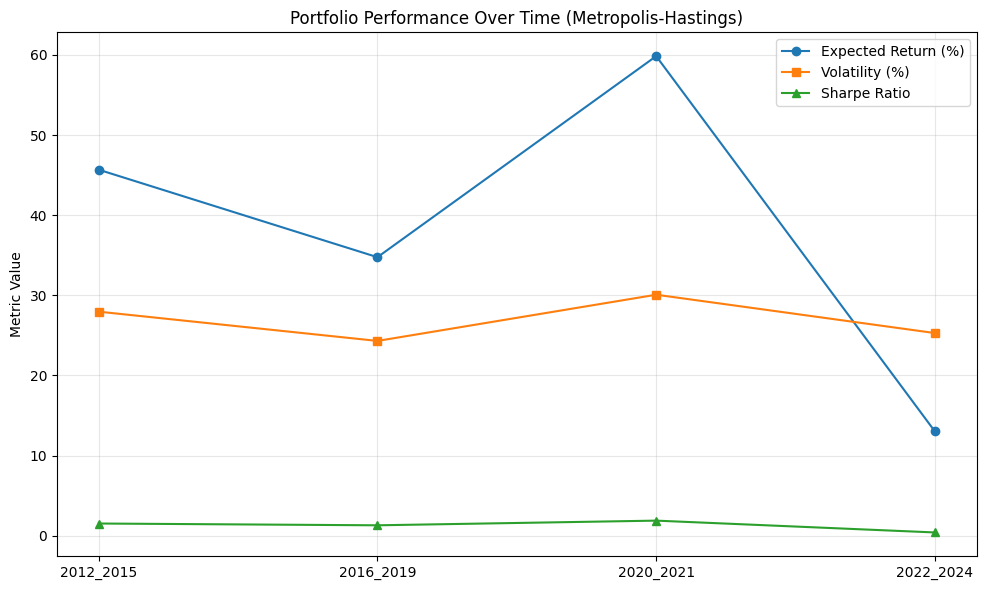

In [ ]:
# Take labels
periods = list(summary_results.keys())

# Create lists from dictionary
returns = [stats['mean_return']*100 for stats in summary_results.values()]
vols    = [stats['mean_vol']*100 for stats in summary_results.values()]
sharpes = [stats['mean_sharpe'] for stats in summary_results.values()]

plt.figure(figsize=(10,6))
plt.plot(periods, returns, marker='o', label='Expected Return (%)')
plt.plot(periods, vols, marker='s', label='Volatility (%)')
plt.plot(periods, sharpes, marker='^', label='Sharpe Ratio')

plt.ylabel("Metric Value")
plt.title("Portfolio Performance Over Time (Metropolis-Hastings)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


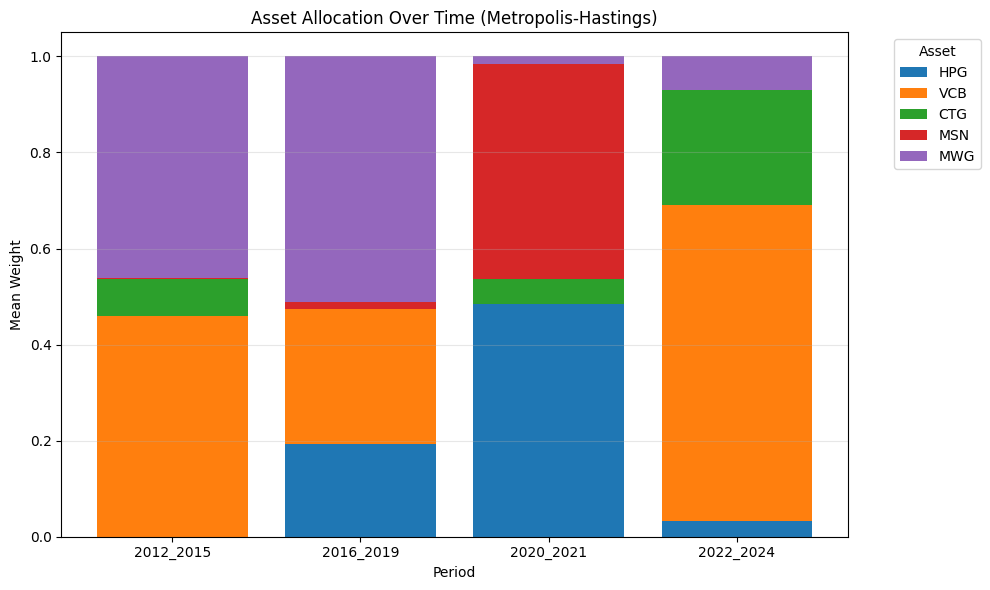


## 👋 Chào mừng bạn đến với Vnstock!

Cảm ơn bạn đã sử dụng package phân tích chứng khoán #1 tại Việt Nam

* Tài liệu: [Sổ tay hướng dẫn](https://vnstocks.com/docs/category/s%E1%BB%95-tay-h%C6%B0%E1%BB%9Bng-d%E1%BA%ABn)
* Cộng đồng: [Nhóm Facebook](https://www.facebook.com/groups/vnstock.official)

Khám phá các tính năng mới nhất và tham gia cộng đồng để nhận hỗ trợ.
                


## 👋 Chào mừng bạn đến với Vnstock!

Cảm ơn bạn đã sử dụng package phân tích chứng khoán #1 tại Việt Nam

* Tài liệu: [Sổ tay hướng dẫn](https://vnstocks.com/docs/category/s%E1%BB%95-tay-h%C6%B0%E1%BB%9Bng-d%E1%BA%ABn)
* Cộng đồng: [Nhóm Facebook](https://www.facebook.com/groups/vnstock.official)

Khám phá các tính năng mới nhất và tham gia cộng đồng để nhận hỗ trợ.
                

In [ ]:
# Stack weights to array (shape: periods x assets)
weights = np.array([stats["mean_weights"] for stats in summary_results.values()])

plt.figure(figsize=(10,6))
bottom = np.zeros(len(weights))

for i, asset in enumerate(ASSETS):
    plt.bar(periods, weights[:, i], bottom=bottom, label=asset)
    bottom += weights[:, i]

plt.title("Asset Allocation Over Time (Metropolis-Hastings)")
plt.ylabel("Mean Weight")
plt.xlabel("Period")
plt.legend(title="Asset", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True, axis='y', alpha=0.3)
plt.show()
